$$Double Pendulum$$

In [1]:
%matplotlib inline

import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from IPython.display import Image

The generaled coordinates for a double pendulum are $\theta_1$ and $\theta_2$. We also make the the ropes have length $l_1$ and $l_2$. Then the postitions are...$$x_1=l_1sin\theta_1$$ $$y_1=l_1cos\theta_1$$ $$x_2=x_1+l_2sin\theta_2$$ $$y_2=y_1+l_2cos\theta_2$$

We then find the velocities of these to be...$$\dot{x_1}=l_1cos\theta_1\dot{\theta_1}$$ $$\dot{y_1}=-l_1sin\theta_1\dot{\theta_1}$$ $$\dot{x_2}=l_1\dot{\theta_1}cos\theta_1+l_2\dot{\theta_2}cos\theta_2$$ $$\dot{y_2}=-l_1\dot{\theta_1}sin\theta_1-l_2\dot{\theta_2}sin\theta_2$$

From these we can find the values of kinetic energy and potential energy:

$$T=\frac{1}{2}m_1v^2_1 + \frac{1}{2}m_2v^2_2=\frac{1}{2}m_1(\dot{x^2_1}+\dot{y^2_1})+\frac{1}{2}m_2(\dot{x^2_2}+\dot{y^2_2})=\frac{1}{2}m_1l^2_1\dot{\theta_1^2}+\frac{1}{2}m_2[l_1^2\dot{\theta^2_1}+l_2^2\dot{\theta^2_2}+2l_1l_2cos(\theta_1-\theta_2)\dot{\theta_1}\dot{\theta_2}]$$

$$U=-m_1gy_1-m_2gy_2=-(m_1+m_2)l_1gcos\theta_1 - m_2l_2gcos\theta_2$$

The Lagrangian $L$, is given by $L=T-U$ meaning...$$L=\frac{1}{2}m_1l^2_1\dot{\theta_1^2}+\frac{1}{2}m_2[l_1^2\dot{\theta^2_1}+l_2^2\dot{\theta^2_2}+2l_1l_2cos(\theta_1-\theta_2)\dot{\theta_1}\dot{\theta_2}]+(m_1+m_2)l_1gcos\theta_1 +m_2l_2gcos\theta_2$$

We recall the Euler-Lagrange equations are: $$\frac{d}{dt}(\frac{\partial{L}}{\partial{\dot{q_i}}})-\frac{\partial{L}}{\partial{q_i}}=0$$

where $q_i=\theta_1,\theta_2$

Note that we must use a change of variables to work with the differential equations package we want to use. We'll let it be that $z_1=\dot{\theta_1}$ and $z_2=\dot{\theta_2}$. The clearly means that $\dot{z_1}=\dot{\dot{\theta_1}}$ and $\dot{z_2}=\dot{\dot{\theta_2}}$

After some work and plugging in for z we find that $$\dot{z_1}=\frac{m_2gsin\theta_2cos(\theta_1-\theta_2)-m_2sin(\theta_1-\theta_2)[l_1z_1^2cos(\theta_1-\theta_2)+l_2^2z_2^2]-(m_1+m_2)gsin\theta_1}{l_1[m_1+m_2sin^2(\theta_1-\theta_2)]}$$

$$\dot{z_2}=\frac{(m_1+m_2)[l_1z_1^2sin(\theta_1-\theta_2)-gsin\theta_2+gsin\theta_1cos(\theta_1-\theta_2)]+m_2l_2z_2^2sin(\theta_1-\theta_2)cos(\theta_1-\theta_2)}{l_2[m_1+m_2sin^2(\theta_1-\theta_2)]}$$

The below image provided by wikipedia shows the double pendulum setup

In [2]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/7/78/Double-Pendulum.svg')

In [3]:
#This class will have the differential equations I need to work with 
#and various other functions which we need to solve the problem. 

class DoublePendulum():
    """
    This class represents a double pendulum, like the one depicted above, that is subject to no driving 
    or damping forces. 
    
    Parameters
    ----------
    L1 : float
        length of the first pendulum
    L2 : float
        length of the second pendulum
    g : float
        strength of gravity 
    mn : float
        mass of the pendulum's where n represents their index number
        
    Methods
    -------
    dy_dt(t,y)
        This returns the right side of the differential equation, which requieres a given value of y and a given 
        value of t. 
    
    """
    def __init__(self,L1=1., L2=1., mass1=1., mass2=1., g=1.
                ):
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.m1 = mass1
        self.m2 = mass2
        
    def dy_dt(self,t,y):
        """
        This function will get us the right hand side of the diff eq. 
        
        Parameters
        ----------
        t : float 
            time
        y : float
            A vector with four components where
            y[0] = theta1 and y[1] = theta1_dot
            y[2] = theta2 and y[2] = theta2_dot
            
        Returns
        -------
        
        
        """
        theta1, z1, theta2, z2 = y
        
        c, s = np.cos(theta1 - theta2), np.sin(theta1 - theta2)
        denom = (self.m1 + self.m2 * s**2)
        
        theta1_dot = z1
        z1_dot = ( self.m2 * self.g * np.sin(theta2) * c \
                  - self.m2 * s * (self.L1 * z1**2 * c + self.L2 * z2**2) \
                  - (self.m1 + self.m2) * self.g * np.sin(theta1) ) \
                / self.L2 / denom
        theta2_dot = z2
        z2_dot = ( (self.m1 + self.m2) * (self.L1 * z1**2 * s \
                - self.g * np.sin(theta2) + self.g * np.sin(theta1) * c)
                + self.m2 * self.L2 * z2**2 * s * c) \
                / self.L2 / denom
        return theta1_dot, z1_dot, theta2_dot, z2_dot
    
    def solve_ode(self, t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0,
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solves the ODE given by the initial conditions. The abserr and relerr
        values determine the error values
        """
        y = [theta1_0, theta1_dot_0, theta2_0, theta2_dot_0]
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]),
                              y, t_eval=t_pts,
                              atol=abserr, rtol=relerr)
        theta1, theta1_dot, theta2, theta2_dot = solution.y
        
        return theta1, theta1_dot, theta2, theta2_dot
    
    def calc_E(y):
        """Gets the total energy of the pendulum/masses"""
        
        th1, th1d, th2, th2d = y.T
        V = -(m1+m2)*L1*g*np.cos(th1) - m2*L2*g*np.cos(th2)
        T = 0.5 * m1 *(L1*th1d)**2 + 0.5*m2*((L1*th1d)**2 + (L2*th2d)**2 +
                                        2*L1*L2*th1d*th2d*np.cos(th1-th2))
        return T + V


In [4]:
#I now need to make a function which plots for us

def plot_Y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    A plotting function which we'll plug everything into to and plot
    """
    if ax is None:
        ax = plot.gca() #this lines makes sure we actually have an x-axis
        
    if (semilogy):
        line, = ax.semilogy(x, y, label=label,
                           color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label,
                           color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label,
                           color=color, linestyle=linestyle)
    
    if label is not None: #Then there is obviously a label we want to include
        ax.legend()
    if title is not None: #Show the title of the plot
        ax.set_title(title)
    if axis_labels is not None:
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])
    
    return ax, line

In [5]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin() #Indexes our points
    stop_index = (np.fabs(t_pts-plot_stop)).argmin() #Ends the indexing process
    return start_index, stop_index

In [6]:
#I now need to make labels for the axes
theta_vs_time_labels = (r'$t$', r'$\theta(t)$')

#Carve up the time we want into little steps
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

L1 = 1.
L2 = 1.
mass1 = 1.
mass2 = 1.
g = 1.
#The above block amounts to choosing units so that everything we're 
#working with is one. 

#Make the double pendulum 
dp1 = DoublePendulum(L1=L1, L2=L2, mass1=mass1, mass2=mass2, g=g)

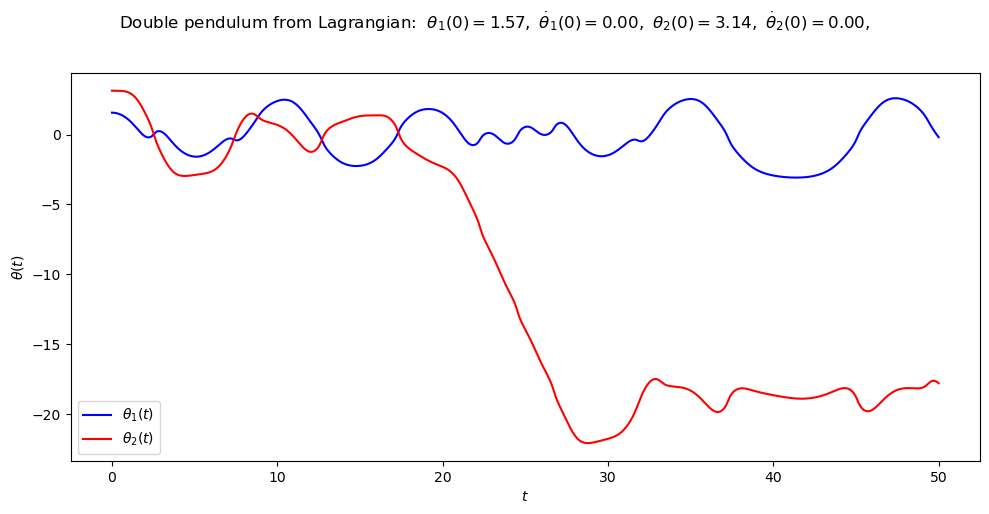

In [7]:
theta1_0 = np.pi/2.
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.
#These define our starting values

theta1, theta_dot, theta2, theta2_dot = \
        dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)

#We are now ready to plot
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian: ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' +\
                rf' $\dot\theta_1(0) = {theta1_dot_0: .2f},$' +\
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta_2(0) = {theta2_dot_0:.2f},$'
#These lines will label our initial conditions on the plot. Later on
#We'll hardly change these ICs and see a very different result which 
#is indictive of chaotic behavior
fig.suptitle(overall_title, va='baseline')

ax_a = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
plot_Y_vs_x(t_pts[start : stop],theta1[start : stop],
            axis_labels=theta_vs_time_labels,
            color='blue',
            label=r'$\theta_1(t)$',
            ax=ax_a)
plot_Y_vs_x(t_pts[start : stop],theta2[start : stop],
            axis_labels=theta_vs_time_labels,
            color='red',
            label=r'$\theta_2(t)$',
            ax=ax_a)

fig.tight_layout()
fig.savefig('double_pendulum_Lagrange_1.png', bbox_inches='tight')

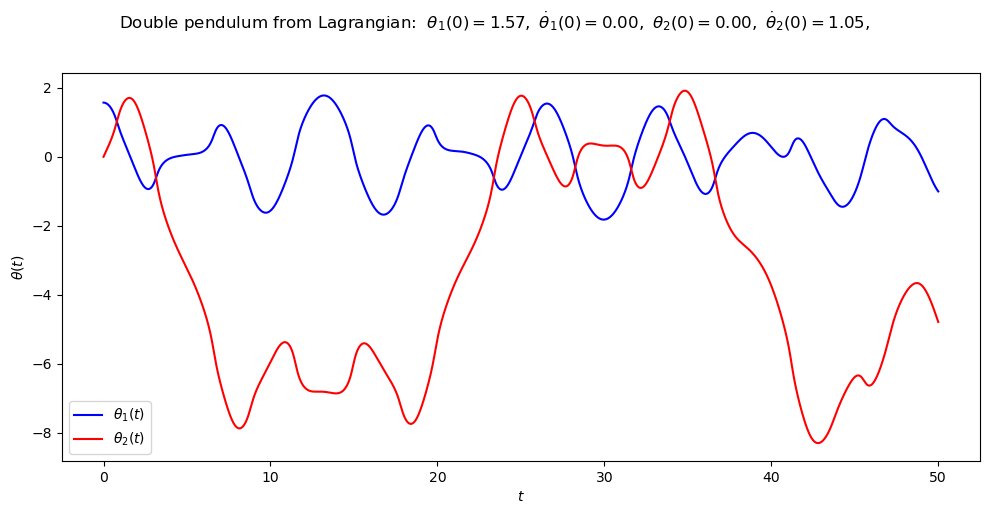

In [8]:
theta1_0 = np.pi/2.
theta1_dot_0 = 0.
theta2_0 = 0.
theta2_dot_0 = np.pi / 3.
#These define our starting values

theta1, theta_dot, theta2, theta2_dot = \
        dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)

#We are now ready to plot
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian: ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' +\
                rf' $\dot\theta_1(0) = {theta1_dot_0: .2f},$' +\
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta_2(0) = {theta2_dot_0:.2f},$'
#These lines will label our initial conditions on the plot. Later on
#We'll hardly change these ICs and see a very different result which 
#is indictive of chaotic behavior
fig.suptitle(overall_title, va='baseline')

ax_a = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
plot_Y_vs_x(t_pts[start : stop],theta1[start : stop],
            axis_labels=theta_vs_time_labels,
            color='blue',
            label=r'$\theta_1(t)$',
            ax=ax_a)
plot_Y_vs_x(t_pts[start : stop],theta2[start : stop],
            axis_labels=theta_vs_time_labels,
            color='red',
            label=r'$\theta_2(t)$',
            ax=ax_a)

fig.tight_layout()
fig.savefig('double_pendulum_Lagrange_1.png', bbox_inches='tight')

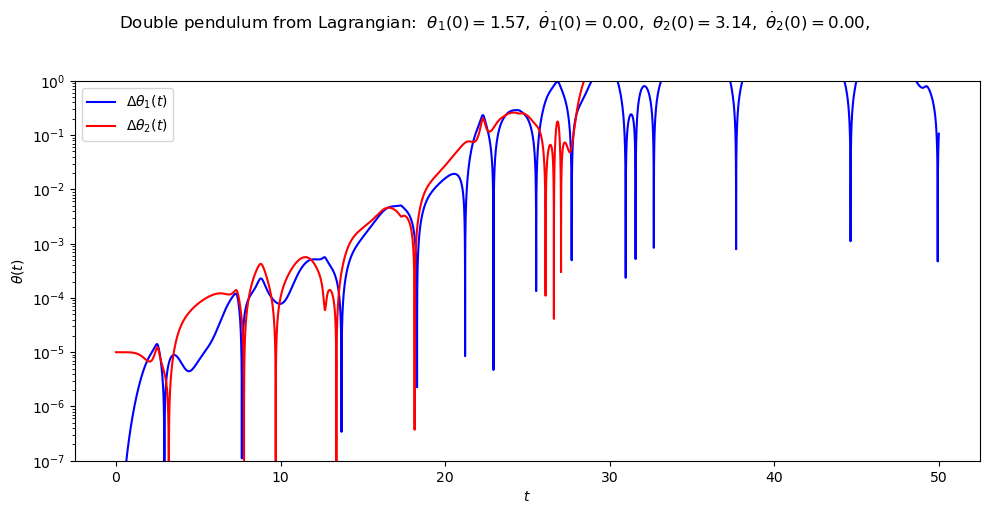

In [9]:
theta1_0 = np.pi/2.
theta1_dot = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.

theta1, theta1_dot, theta2, theta2_dot = \
    dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)
theta1b, theta1b_dot, theta2b, theta2b_dot = \
    dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0-0.00001, theta2_dot_0)

#Now we start making the plot. Note that the b plot is different from the a plot 
#only in that theta2_0 starts 0.00001 units of length behind theta2_0
#we expect that in the begenning their behavior will be similar and as time goes 
#by the difference in their motion will be quite different

fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian: ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf' $\dot\theta_1(0) = {theta1_dot_0:.2f},$' +\
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta_2(0) = {theta2_dot_0:.2f},$'
fig.suptitle(overall_title, va='baseline')

ax_a = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
plot_Y_vs_x(t_pts[start : stop], np.abs(theta1[start : stop] - theta1b[start : stop]),
           axis_labels = theta_vs_time_labels,
           color = 'blue', semilogy = True,
           label=r'$\Delta\theta_1(t)$',
           ax=ax_a)
plot_Y_vs_x(t_pts[start : stop], np.abs(theta2[start : stop]-theta2b[start : stop]),
            color = 'red', semilogy=True,
            label=r'$\Delta\theta_2(t)$',
            ax=ax_a)

ax_a.set_ylim(1.e-7, 1.)

fig.tight_layout()
fig.savefig('double_pendulum_Lagrange_2.png', bbox_inches='tight')

We clearly see that as time progresses the difference in the position of the two pendulums also grows, to a point where there difference in spatial units is greater than one. This means that the motion of the two systems is very different even though their starting conditions for the second mass (the lower one) differed by less than $.0001$ units. This is textbook chaotic behavior. The below animation should make the behavior even more apperent.

In [10]:
from matplotlib import animation, rc
from IPython.display import HTML

In [11]:
def xy_coords(x0, y0, theta, L):
    """
    This turns the values of theta into the positions of the masses so
    that when we animate the masses move as they should
    """
    x = x0 + L * np.sin(theta)
    y = y0 - L * np.cos(theta)
    return x, y

In [12]:
%%capture
x_min = -3.2
x_max = -x_min
y_min = -3.2
y_max = -y_min

fig_anim = plt.figure(figsize=(5,5), num='Double pendulum')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min, x_max)
ax_anim.set_ylim(y_min, y_max)

#This is like the first frame in our animation which we will 
#devlope in small steps from
x0, y0 = 0., 0.
pt0_anim, = ax_anim.plot(x0, y0,
                          'o', markersize=6,
                          color='black')

x1, y1 = xy_coords(x0, y0, theta1[0], dp1.L1)
pt1_anim, = ax_anim.plot(x1, y1,
                         'o', markersize=12,
                         color='blue')
ln1_anim, = ax_anim.plot([x0,x1], [y0,y1], color='blue', lw=3)
x2, y2 = xy_coords(x1, y1, theta2[0], dp1.L2)
pt2_anim, = ax_anim.plot(x2, y2,
                        'o', markersize=12,
                         color='blue')
ln2_anim, = ax_anim.plot([x1,x2], [y1,y2], color='blue', lw=3)

x1b, y1b = xy_coords(x0, y0, theta1b[0], dp1.L1)
pt1b_anim, = ax_anim.plot(x1b, y1b,
                          'o', markersize=12,
                          color='red')
ln1b_anim, = ax_anim.plot([x0, x1b], [y0,y1b], color='red', lw=3)
x2b, y2b = xy_coords(x1b, y1b, theta2b[0], dp1.L2)
pt2b_anim, = ax_anim.plot(x2b, y2b,
                          'o', markersize=12,
                          color='red')
ln2b_anim, = ax_anim.plot([x1b, x2b], [y1b, y2b], color='red', lw=3)


ax_anim.set_aspect(1)
ax_anim.axis('off')
fig_anim.tight_layout()

In [13]:
def animate_pendulum(i):
    """
    This is the function which animates each frame, made above. 
    """
    
    i_skip = 2 * i
    
    x0, y0 = 0., 0.
    pt0_anim.set_data(x0, y0)
    
    x1, y1 = xy_coords(x0, y0, theta1[i_skip], dp1.L1)
    pt1_anim.set_data(x1,y1)
    ln1_anim.set_data([x0,x1],[y0,y1])
    x2, y2 = xy_coords(x1, y1, theta2[i_skip], dp1.L2)
    pt2_anim.set_data(x2, y2)
    ln2_anim.set_data([x1, x2],[y1, y2])
    
    x1b, y1b = xy_coords(x0, y0, theta1b[i_skip], dp1.L1)
    pt1b_anim.set_data(x1b, y1b)
    ln1b_anim.set_data([x0, x1b], [y0, y1b])
    x2b, y2b = xy_coords(x1b, y1b, theta2b[i_skip], dp1.L2)
    pt2b_anim.set_data(x2b, y2b)
    ln2b_anim.set_data([x1b, x2b], [y1b, y2b])
    
    return (pt0_anim, pt1_anim, ln1_anim, pt2_anim, ln2_anim,
            pt1b_anim, ln1b_anim, pt2b_anim, ln2b_anim)

In [14]:
frame_interval = 20.
frame_number = 1001
anim = animation.FuncAnimation(fig_anim,
                               animate_pendulum,
                               init_func=None,
                               frames=frame_number,
                               interval=frame_interval,
                               blit=True,
                               repeat=False)

In [15]:
HTML(anim.to_jshtml())

$$Triple Pendulum$$